# Problem 1

**Problem 1** is a binary classification problem for each user. The problem asks to predict if a customer would purchase any box within the first two weeks of March or not. We'll start by verifying the datasets.

In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/robi-datathon-30-qualifier-problem-1/boxes.csv
/kaggle/input/robi-datathon-30-qualifier-problem-1/sample submission 1.csv
/kaggle/input/robi-datathon-30-qualifier-problem-1/problem 1.csv
/kaggle/input/robi-datathon-30-qualifier-problem-1/purchase.csv


## Boxes Dataset
The boxes dataset contains a set of boxes with varying properties. This does ensure that even the continuous values within its features are discretised to a possible pool of limited values.

In [5]:
boxes_df = pd.read_csv('/kaggle/input/robi-datathon-30-qualifier-problem-1/boxes.csv')
boxes_df.head()

,BOX_ID,QUALITY,DELIVERY_OPTION,MILK,MEAT,UNIT_PRICE
0,1,Premium,Home Delivery - CoD,0.0,2.7,9.96
1,2,Premium,Home Delivery - CoD,0.0,2.3,11.96
2,3,Premium,Home Delivery - CoD,0.0,2.4,11.96
3,4,Premium,Home Delivery - CoD,0.0,2.5,11.96
4,5,Premium,Home Delivery - CoD,0.0,2.6,11.96
...,...,...,...,...,...,...
285,286,Standard,Home Delivery - Digital Payment,0.0,4.0,15.96
286,287,Standard,Home Delivery - Digital Payment,0.0,2.9,15.96
287,288,Standard,Home Delivery - Digital Payment,0.0,3.6,15.96
288,289,Standard,Home Delivery - Digital Payment,0.0,4.7,15.96


## Purchase Dataset
The purchase dataset contains the historical data of a sample of customers within a 5 month window.

In [6]:
purchase_df = pd.read_csv('/kaggle/input/robi-datathon-30-qualifier-problem-1/purchase.csv')
purchase_df.head()

,PURCHASE_DATE,MAGIC_KEY,BOX_ID,BOX_COUNT
0,1/2/2019,2CED678A247,12.0,1.0
1,1/2/2019,2BF58D91BA1,12.0,1.0
2,1/2/2019,2C15B86534E,99.0,1.0
3,1/2/2019,2C32D9A859A,6.0,1.0
4,1/2/2019,2C7A55404D1,4.0,1.0
...,...,...,...,...
2455859,28/10/2018,2BD992B5538,12.0,1.0
2455860,28/10/2018,2C97CD72233,17.0,1.0
2455861,28/10/2018,2C91C61D372,40.0,1.0
2455862,28/10/2018,2CD70CFC4E3,51.0,1.0


## Test Data Cursory Observation

It seems that there are **no features** that we can use throughout the **prediction period** since only the IDs of the customers to predict for have been given. This generally makes the applications of **traditional supervised machine learning approaches** quite inconvenient since they require features on the test set to be present to make predictions. One approach would be to engineer some features but for this binary classification task, we can go with much simpler statistical models.

In [8]:
test_df = pd.read_csv('/kaggle/input/robi-datathon-30-qualifier-problem-1/problem 1.csv')
test_df.head()

,MAGIC_KEY
0,28D5BB06356
1,293BEAB4E98
2,2962EE8065C
3,2957BE29EA9
4,28E351A0745
...,...
58684,28FB7C09776
58685,28E0E3B69BF
58686,28D343103A7
58687,290B1D6D5CB


## Purchase History
For convenience, we will merge the box dataset with the customer dataset to get a holistic idea of their purchase history. This will act as the single source of truth from here on.

In [10]:
merged_df = pd.merge(boxes_df, purchase_df, on='BOX_ID', how='inner')
merged_df = pd.merge(merged_df, test_df, on='MAGIC_KEY', how='inner')
merged_df['PURCHASE_DATE'] = pd.to_datetime(merged_df['PURCHASE_DATE'], format='%d/%m/%Y')
merged_df.sort_values(by='PURCHASE_DATE', inplace=True)
merged_df

,BOX_ID,QUALITY,DELIVERY_OPTION,MILK,MEAT,UNIT_PRICE,PURCHASE_DATE,MAGIC_KEY,BOX_COUNT
173224,260,Standard,Delivery from Collection Point,10.0,1.8,17.98,2018-10-01,28F7149F212,1.0
173520,260,Standard,Delivery from Collection Point,10.0,1.8,17.98,2018-10-01,28F5A97CCFA,1.0
173519,260,Standard,Delivery from Collection Point,10.0,1.8,17.98,2018-10-01,28D9482F056,1.0
173518,260,Standard,Delivery from Collection Point,10.0,1.8,17.98,2018-10-01,28D54D10BC1,1.0
10507,207,Standard,Home Delivery - CoD,0.0,2.7,13.96,2018-10-01,29767C453FD,1.0
...,...,...,...,...,...,...,...,...,...
19709,217,Standard,Home Delivery - CoD,10.0,2.5,17.98,2019-02-28,28D2A46141D,1.0
19708,217,Standard,Home Delivery - CoD,10.0,2.5,17.98,2019-02-28,28F54E4C1E5,1.0
19707,217,Standard,Home Delivery - CoD,10.0,2.5,17.98,2019-02-28,28F8A2F53EE,1.0
25465,230,Standard,Delivery from Collection Point,8.4,0.0,10.14,2019-02-28,28E543976E8,1.0


Now we need to have a look into the **purchase counts for each customer.** This might lead to discovering some trivial cases.

count    58689.000000
mean         3.724753
std          1.628324
min          2.000000
25%          3.000000
50%          4.000000
75%          5.000000
max         38.000000
Name: P_COUNT, dtype: float64


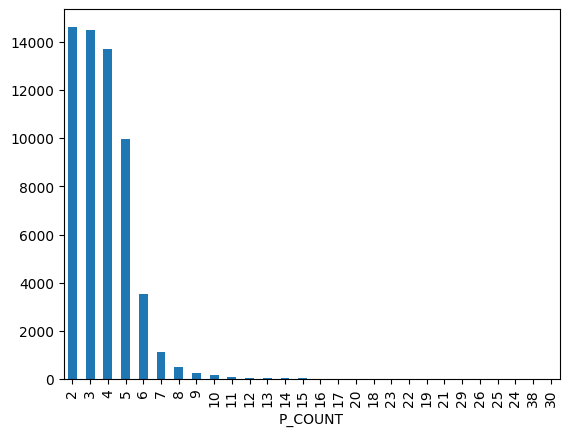

In [16]:
aggr_df = merged_df.groupby('MAGIC_KEY').size().reset_index(name='P_COUNT')
print(aggr_df['P_COUNT'].describe())
aggr_df['P_COUNT'].value_counts().plot(kind='bar')
plt.show()

It seems that there is **no customer within this test set** who purchases a box exactly once. 75% of the customers make somewhere between 2 to 5 purchases.

## Exploring the Trends

The next step is to explore the time-series trend of the additive numeric variables. We bucket the amount of total milk, meat consumed and the total number of boxes sold in a single day.

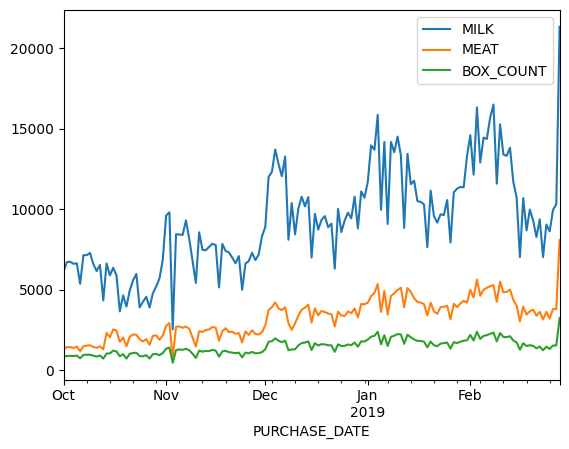

In [20]:
merged_df_mini = merged_df.drop(['BOX_ID', 'QUALITY', 'DELIVERY_OPTION', 'UNIT_PRICE'], axis=1)
daily_data = merged_df_mini.resample('D', on='PURCHASE_DATE').sum()
daily_data.plot()
plt.show()

This yields a quite distiguishable phenomena. Each of these variables **spike near boundaries between two months**. This is most likely due to people receiving their salaries during that timeframe, causing an upward surge. The **overall tendency** of these variables is **also upward**, suggesting that consumption is increasing in general. This can either be explained by:

- The population increasing since these values are not normalised with respect to the population
- People getting wealthier in general

Since, there is some degree of seasonality observed from this simple graph, we will proceed to dig a bit deeper into the data by doing a decomposition with the daily data.

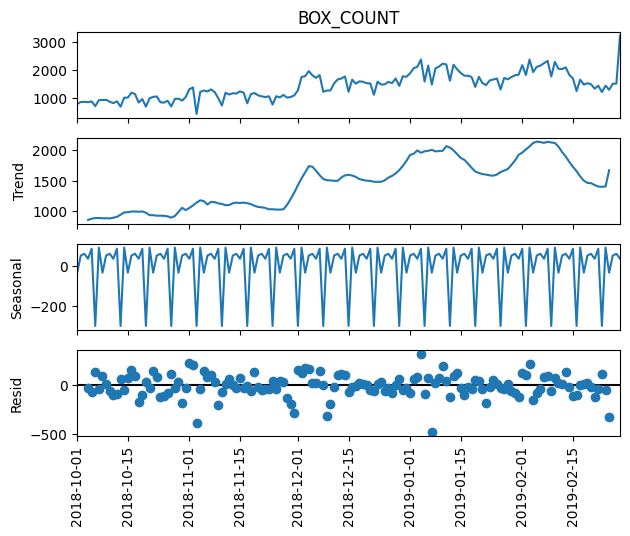

In [25]:
result = seasonal_decompose(daily_data['BOX_COUNT'], model='additive')
result.plot()
plt.xticks(rotation=90)
plt.show()

This confirms the upward tendency that we mentioned previously with some smoothing applied. Also, we can observe **some degree of seasonality** clearly.

Now, let's have a look at the **trend of unit prices**. Since this is not additive like the other numeric variables, we choose to do the daily grouping via taking the mean.

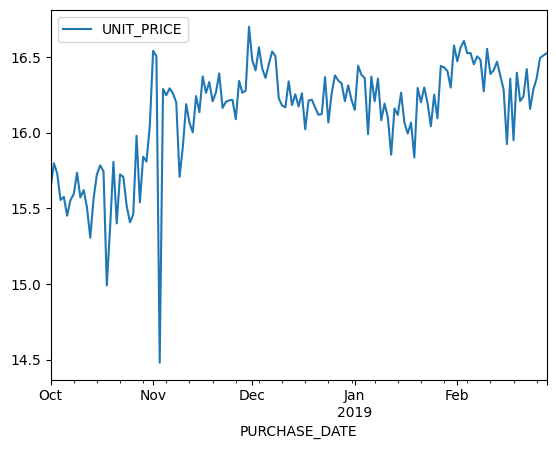

In [28]:
merged_df[['PURCHASE_DATE', 'UNIT_PRICE']].resample('D', on='PURCHASE_DATE').mean().plot()
plt.show()

There is clearly an upward tendency. This can be explained via:
- Inflation
- The previous hypothesis of people becoming wealthier in general

## Exploring the Categorical Variables

Since we're done dealing with the numerical variables, let's have the insight into the categorical variables.

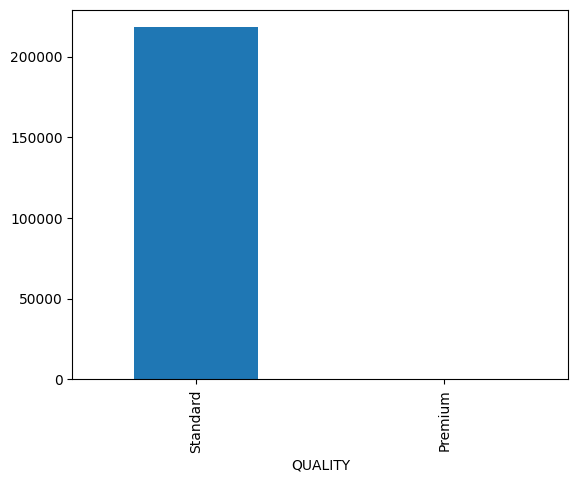

In [30]:
quality_counts = merged_df['QUALITY'].value_counts()
quality_counts.plot(kind='bar')
plt.show()

This is completely dominated by a single class. There isn't any useful information to gain from this feature. There is not a single premium box in this dataset.

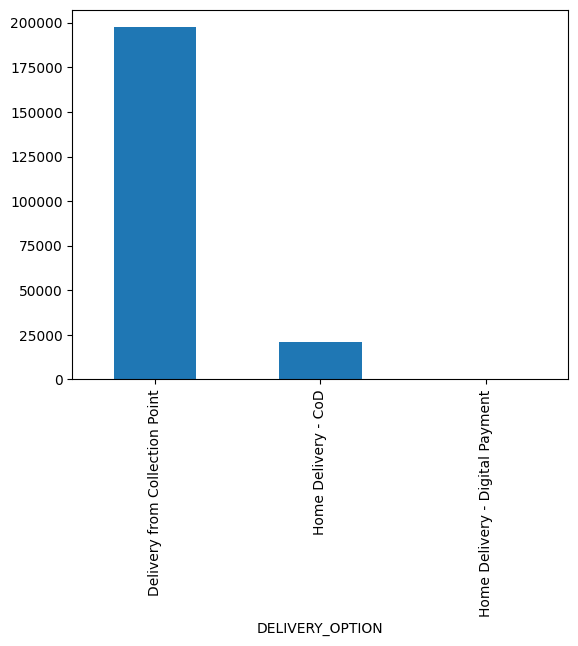

In [31]:
delivery_counts = merged_df['DELIVERY_OPTION'].value_counts()
delivery_counts.plot(kind='bar')
plt.show()

Same story here, the skew towards a single class is too high for it bear any meaningful pattern.

This concludes the categorical classes. **They won't be useful for this binary classification task** and hence will be dropped from any future considerations.

## Narrowing the Focus

Okay, so we have observed some clear seasonality in the data. Now how do we infer what the ideal cycle for a customer might be? One approach is to make some estimation based on the dates of the intermittent purchases of a user. We narrow our focus to three variables for this cause: the purchase date and the box count.

In [33]:
micro_df_filtered = merged_df[['PURCHASE_DATE', 'MAGIC_KEY', 'BOX_COUNT']]
micro_df_filtered

,PURCHASE_DATE,MAGIC_KEY,BOX_COUNT
173224,2018-10-01,28F7149F212,1.0
173520,2018-10-01,28F5A97CCFA,1.0
173519,2018-10-01,28D9482F056,1.0
173518,2018-10-01,28D54D10BC1,1.0
10507,2018-10-01,29767C453FD,1.0
...,...,...,...
19709,2019-02-28,28D2A46141D,1.0
19708,2019-02-28,28F54E4C1E5,1.0
19707,2019-02-28,28F8A2F53EE,1.0
25465,2019-02-28,28E543976E8,1.0


We want to normalise the periods **with respect to the amount of boxes purchased each time**. The intuition is that **more boxes will take longer to exhaust**. So if a customer chooses to shift from buying single boxes to double boxes (or more), the period till their next purchase should multiply by that amount.

*This obviously has the assumption that a customer would only purchase once their stocks end, which should be good enough to model most of the cases.*

In [36]:
per_customer = micro_df_filtered.groupby('MAGIC_KEY')
per_customer = per_customer.apply(lambda gdf: gdf.assign(EXHAUSTION=lambda gdf: gdf['PURCHASE_DATE'].diff().dt.days / gdf['BOX_COUNT'].shift()), include_groups=False)
per_customer.reset_index(inplace=True)
per_customer

,MAGIC_KEY,level_1,PURCHASE_DATE,BOX_COUNT,EXHAUSTION
0,2498CA210F2,68559,2018-12-06,1.0,NaN
1,2498CA210F2,60335,2019-02-05,1.0,61.0
2,249BD4201E6,120,2019-01-14,1.0,NaN
3,249BD4201E6,84,2019-02-13,1.0,30.0
4,249C911B64A,78942,2018-10-05,1.0,NaN
...,...,...,...,...,...
218597,297D1A68BFD,180200,2019-02-10,1.0,30.0
218598,297D1AE218B,175318,2018-10-11,1.0,NaN
218599,297D1AE218B,163298,2018-11-18,1.0,38.0
218600,297D1AE218B,146747,2019-01-16,1.0,59.0


This bit of code does the trick. It finds the days passed between each consecutive purchase. The first gap would be invalid, and we wouldn't want it to affect our calculations with some placeholder value like a zero.
Fortunately, there are **at least two purchases** for each customer. So we can filter these out, and while we're at it, we should also **filter the outliers out** to make the mean a better representative value of the given data.

In [37]:
per_customer_grouped = per_customer.groupby('MAGIC_KEY')['EXHAUSTION']
Q1 = per_customer_grouped.quantile(0.25)
Q3 = per_customer_grouped.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
upper_bound

MAGIC_KEY
2498CA210F2    61.000
249BD4201E6    30.000
249C911B64A    35.000
249D123A385    62.500
249DA1DC108    31.000
                ...  
297D14BF319    31.000
297D17F1EED    33.750
297D18E7B24    33.250
297D1A68BFD    58.375
297D1AE218B    77.000
Name: EXHAUSTION, Length: 58689, dtype: float64

We go with a basic interquartile range based method. It's computationally efficient and should serve the cause for this task.

In [44]:
def filter_outliers(group):
    lower = lower_bound[group.name]
    upper = upper_bound[group.name]
    return group[(group['EXHAUSTION'] >= lower) & (group['EXHAUSTION'] <= upper)]

per_customer_no_outlier = per_customer.groupby('MAGIC_KEY').apply(filter_outliers, include_groups=False)
per_customer_no_outlier = per_customer_no_outlier.drop(columns='level_1').reset_index().drop(columns='level_1')
per_customer_no_outlier

In [50]:
per_customer_mean = per_customer_no_outlier.groupby('MAGIC_KEY')['EXHAUSTION'].mean().reset_index()
per_customer_mean

,MAGIC_KEY,EXHAUSTION
0,2498CA210F2,61.000000
1,249BD4201E6,30.000000
2,249C911B64A,22.833333
3,249D123A385,57.500000
4,249DA1DC108,31.000000
...,...,...
58684,297D14BF319,30.000000
58685,297D17F1EED,29.666667
58686,297D18E7B24,29.000000
58687,297D1A68BFD,22.666667


In [51]:
per_customer_no_outlier = pd.merge(per_customer_no_outlier.drop(columns=['EXHAUSTION']), per_customer_mean, on='MAGIC_KEY')
per_customer_no_outlier

,MAGIC_KEY,PURCHASE_DATE,BOX_COUNT,EXHAUSTION
0,2498CA210F2,2019-02-05,1.0,61.000000
1,249BD4201E6,2019-02-13,1.0,30.000000
2,249C911B64A,2018-10-23,1.0,22.833333
3,249C911B64A,2018-11-12,1.0,22.833333
4,249C911B64A,2018-12-11,1.0,22.833333
...,...,...,...,...
153015,297D1A68BFD,2018-11-11,1.0,22.666667
153016,297D1A68BFD,2019-02-10,1.0,22.666667
153017,297D1AE218B,2018-11-18,1.0,39.333333
153018,297D1AE218B,2019-01-16,1.0,39.333333


Now we have the periodicity of purchases for each customer that is robust to outliers. We may now move on to the final stage, that is predicting a potential date for the customer's next purchase. We can, however, reduce the problem to a simpler case. Using the date we get from the customer's periodicity, we can use the standard deviation of the periodicity to get a range of possible dates, and **see if the range overlaps with the first two weeks of March**. This yields us the desired values for the first iteration of our binary classification task.

In [52]:
def predictor(gdf):
    # Calculate the difference in days between the target_date and the last_date
    target_date_start = pd.to_datetime('2019-03-01')
    target_date_end = pd.to_datetime('2019-03-15')
    last_date = gdf['PURCHASE_DATE'].max()
    last_box_count = gdf[gdf['PURCHASE_DATE'] == last_date]['BOX_COUNT'].mean()
    
    next_date_pred = last_date + pd.DateOffset(int(gdf['EXHAUSTION'].mean() * last_box_count))
    next_date_pred_start = next_date_pred - pd.DateOffset(int(gdf['EXHAUSTION'].std() if not np.isnan(gdf['EXHAUSTION'].std()) else 0))
    next_date_pred_end = next_date_pred + pd.DateOffset(int(gdf['EXHAUSTION'].std() if not np.isnan(gdf['EXHAUSTION'].std()) else 0))
    
    if (target_date_start <= next_date_pred_start <= target_date_end) or (target_date_start <= next_date_pred_end <= target_date_end):
        return 'Y'
    else:
        return 'N'
    
per_customer_pred = per_customer_no_outlier.groupby('MAGIC_KEY').apply(predictor, include_groups=False).reset_index()

In [53]:
per_customer_pred

,MAGIC_KEY,0
0,2498CA210F2,N
1,249BD4201E6,Y
2,249C911B64A,Y
3,249D123A385,N
4,249DA1DC108,Y
...,...,...
58684,297D14BF319,Y
58685,297D17F1EED,N
58686,297D18E7B24,N
58687,297D1A68BFD,Y


In [54]:
pred_df = pd.DataFrame(per_customer_pred)
pred_df.rename(columns={0: 'PURCHASE'}, inplace=True)
pred_df

,MAGIC_KEY,PURCHASE
0,2498CA210F2,N
1,249BD4201E6,Y
2,249C911B64A,Y
3,249D123A385,N
4,249DA1DC108,Y
...,...,...
58684,297D14BF319,Y
58685,297D17F1EED,N
58686,297D18E7B24,N
58687,297D1A68BFD,Y


In [55]:
phase_one = pd.merge(pred_df, test_df, on='MAGIC_KEY', how='right').fillna('N')  # For consistent ordering
phase_one

,MAGIC_KEY,PURCHASE
0,28D5BB06356,N
1,293BEAB4E98,N
2,2962EE8065C,Y
3,2957BE29EA9,N
4,28E351A0745,N
...,...,...
58684,28FB7C09776,N
58685,28E0E3B69BF,N
58686,28D343103A7,Y
58687,290B1D6D5CB,Y


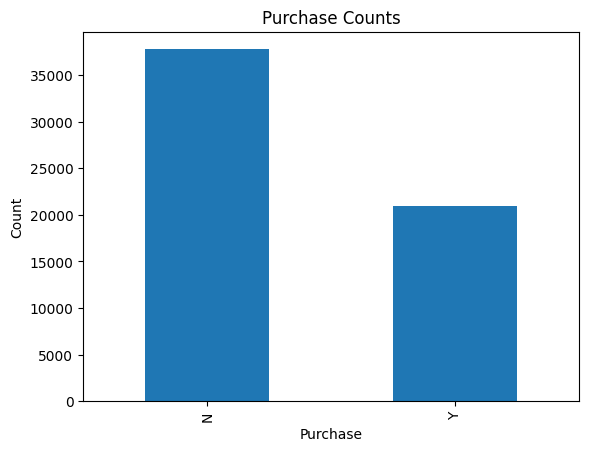

In [56]:
purchase_counts = phase_one['PURCHASE'].value_counts()

# Plot a bar chart
purchase_counts.plot(kind='bar')

# Add title and labels
plt.title('Purchase Counts')
plt.xlabel('Purchase')
plt.ylabel('Count')

# Show the plot
plt.show()

Now for the plot of the predicted values. It seems that the predictions are skewed towards having less purchases. From empirical observation, the difference between these two classes should be much lower. Hence, we will try to work our way through some of the false negatives to turn them into positives.

In [ ]:
final_output.to_csv('output.csv', index=False)

In [58]:
purchase_counts

PURCHASE
N    37744
Y    20945
Name: count, dtype: int64

We will now try to engineer some features that we can use to make more informed decisions on what can and cannot be flipped. Let's start off with a detailed summary of each of the customer's purchase histories.

In [57]:
merged_df_stats = merged_df.groupby('MAGIC_KEY').agg(
    total_purchase =('MAGIC_KEY', 'size'),
    first_purchase_date=('PURCHASE_DATE', 'min'),
    last_purchase_date=('PURCHASE_DATE', 'max'), 
    no_of_different_boxes_purchased=('BOX_ID', 'nunique'),
    most_frequently_purchased_box_id=('BOX_ID', lambda x: x.value_counts().idxmax() if not x.empty else None),

    sum_unit_price=('UNIT_PRICE', 'sum'),  
    avg_milk=('MILK', 'mean'), 
    total_milk=('MILK', 'sum'),  
    avg_meat=('MEAT', 'mean'), 
    total_meat=('MEAT', 'sum'),  
    no_of_different_quality=('QUALITY','nunique'),
    most_preferable_quality=('QUALITY', lambda x: x.mode().iloc[0] if not x.mode().empty else None),  
    no_of_different_delivery_option=('DELIVERY_OPTION','nunique'),
    most_preferable_delivery_option=('DELIVERY_OPTION', lambda x: x.mode().iloc[0] if not x.mode().empty else None) 
).reset_index()
merged_df_stats

,MAGIC_KEY,total_purchase,first_purchase_date,last_purchase_date,no_of_different_boxes_purchased,most_frequently_purchased_box_id,sum_unit_price,avg_milk,total_milk,avg_meat,total_meat,no_of_different_quality,most_preferable_quality,no_of_different_delivery_option,most_preferable_delivery_option
0,2498CA210F2,2,2018-12-06,2019-02-05,1,246,27.92,0.000000,0.0,2.500000,5.0,1,Standard,1,Delivery from Collection Point
1,249BD4201E6,2,2019-01-14,2019-02-13,2,108,31.92,0.000000,0.0,3.800000,7.6,1,Premium,1,Delivery from Collection Point
2,249C911B64A,7,2018-10-05,2019-02-19,2,255,109.72,0.000000,0.0,3.471429,24.3,1,Standard,1,Delivery from Collection Point
3,249D123A385,3,2018-10-28,2019-02-20,2,258,49.92,5.333333,16.0,2.300000,6.9,1,Standard,1,Delivery from Collection Point
4,249DA1DC108,2,2019-01-02,2019-02-02,1,255,31.92,0.000000,0.0,3.600000,7.2,1,Standard,1,Delivery from Collection Point
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58684,297D14BF319,5,2018-10-16,2019-02-13,2,258,91.90,9.600000,48.0,2.120000,10.6,1,Standard,1,Delivery from Collection Point
58685,297D17F1EED,5,2018-10-15,2019-02-04,2,258,91.90,9.600000,48.0,2.120000,10.6,1,Standard,1,Delivery from Collection Point
58686,297D18E7B24,5,2018-10-23,2019-02-16,3,271,97.90,14.400000,72.0,2.040000,10.2,1,Standard,1,Delivery from Collection Point
58687,297D1A68BFD,5,2018-10-04,2019-02-10,4,270,84.90,13.740000,68.7,1.200000,6.0,1,Standard,1,Delivery from Collection Point


In [72]:
most_recent_date = merged_df['PURCHASE_DATE'].max()
merged_df_stats['days_since_last_purchase'] = (most_recent_date - merged_df_stats['last_purchase_date']).dt.days
merged_df_stats['purchase_duration'] = (merged_df_stats['last_purchase_date'] - merged_df_stats['first_purchase_date']).dt.days
merged_df_stats

,MAGIC_KEY,total_purchase,first_purchase_date,last_purchase_date,no_of_different_boxes_purchased,most_frequently_purchased_box_id,sum_unit_price,avg_milk,total_milk,avg_meat,total_meat,no_of_different_quality,most_preferable_quality,no_of_different_delivery_option,most_preferable_delivery_option,days_since_last_purchase,purchase_duration
0,2498CA210F2,2,2018-12-06,2019-02-05,1,246,27.92,0.000000,0.0,2.500000,5.0,1,Standard,1,Delivery from Collection Point,23,61
1,249BD4201E6,2,2019-01-14,2019-02-13,2,108,31.92,0.000000,0.0,3.800000,7.6,1,Premium,1,Delivery from Collection Point,15,30
2,249C911B64A,7,2018-10-05,2019-02-19,2,255,109.72,0.000000,0.0,3.471429,24.3,1,Standard,1,Delivery from Collection Point,9,137
3,249D123A385,3,2018-10-28,2019-02-20,2,258,49.92,5.333333,16.0,2.300000,6.9,1,Standard,1,Delivery from Collection Point,8,115
4,249DA1DC108,2,2019-01-02,2019-02-02,1,255,31.92,0.000000,0.0,3.600000,7.2,1,Standard,1,Delivery from Collection Point,26,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58684,297D14BF319,5,2018-10-16,2019-02-13,2,258,91.90,9.600000,48.0,2.120000,10.6,1,Standard,1,Delivery from Collection Point,15,120
58685,297D17F1EED,5,2018-10-15,2019-02-04,2,258,91.90,9.600000,48.0,2.120000,10.6,1,Standard,1,Delivery from Collection Point,24,112
58686,297D18E7B24,5,2018-10-23,2019-02-16,3,271,97.90,14.400000,72.0,2.040000,10.2,1,Standard,1,Delivery from Collection Point,12,116
58687,297D1A68BFD,5,2018-10-04,2019-02-10,4,270,84.90,13.740000,68.7,1.200000,6.0,1,Standard,1,Delivery from Collection Point,18,129


In [73]:
merged_df_stats_pred = pd.merge(merged_df_stats, phase_one, on="MAGIC_KEY", how="left")
merged_df_stats_pred

,MAGIC_KEY,total_purchase,first_purchase_date,last_purchase_date,no_of_different_boxes_purchased,most_frequently_purchased_box_id,sum_unit_price,avg_milk,total_milk,avg_meat,total_meat,no_of_different_quality,most_preferable_quality,no_of_different_delivery_option,most_preferable_delivery_option,days_since_last_purchase,purchase_duration,PURCHASE
0,2498CA210F2,2,2018-12-06,2019-02-05,1,246,27.92,0.000000,0.0,2.500000,5.0,1,Standard,1,Delivery from Collection Point,23,61,N
1,249BD4201E6,2,2019-01-14,2019-02-13,2,108,31.92,0.000000,0.0,3.800000,7.6,1,Premium,1,Delivery from Collection Point,15,30,Y
2,249C911B64A,7,2018-10-05,2019-02-19,2,255,109.72,0.000000,0.0,3.471429,24.3,1,Standard,1,Delivery from Collection Point,9,137,Y
3,249D123A385,3,2018-10-28,2019-02-20,2,258,49.92,5.333333,16.0,2.300000,6.9,1,Standard,1,Delivery from Collection Point,8,115,N
4,249DA1DC108,2,2019-01-02,2019-02-02,1,255,31.92,0.000000,0.0,3.600000,7.2,1,Standard,1,Delivery from Collection Point,26,31,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58684,297D14BF319,5,2018-10-16,2019-02-13,2,258,91.90,9.600000,48.0,2.120000,10.6,1,Standard,1,Delivery from Collection Point,15,120,Y
58685,297D17F1EED,5,2018-10-15,2019-02-04,2,258,91.90,9.600000,48.0,2.120000,10.6,1,Standard,1,Delivery from Collection Point,24,112,N
58686,297D18E7B24,5,2018-10-23,2019-02-16,3,271,97.90,14.400000,72.0,2.040000,10.2,1,Standard,1,Delivery from Collection Point,12,116,N
58687,297D1A68BFD,5,2018-10-04,2019-02-10,4,270,84.90,13.740000,68.7,1.200000,6.0,1,Standard,1,Delivery from Collection Point,18,129,Y


We will now filter out the customers of interest: the false negative and integrate them into the detailed summary.

In [74]:
merged_df_stats_pred_neg = merged_df_stats_pred[merged_df_stats_pred['PURCHASE'] == 'N']
merged_df_stats_pred_neg

,MAGIC_KEY,total_purchase,first_purchase_date,last_purchase_date,no_of_different_boxes_purchased,most_frequently_purchased_box_id,sum_unit_price,avg_milk,total_milk,avg_meat,total_meat,no_of_different_quality,most_preferable_quality,no_of_different_delivery_option,most_preferable_delivery_option,days_since_last_purchase,purchase_duration,PURCHASE
0,2498CA210F2,2,2018-12-06,2019-02-05,1,246,27.92,0.000000,0.0,2.500000,5.0,1,Standard,1,Delivery from Collection Point,23,61,N
3,249D123A385,3,2018-10-28,2019-02-20,2,258,49.92,5.333333,16.0,2.300000,6.9,1,Standard,1,Delivery from Collection Point,8,115,N
5,249EA714089,6,2018-10-02,2019-02-24,2,258,107.88,8.333333,50.0,2.133333,12.8,1,Standard,1,Delivery from Collection Point,4,145,N
6,249EDB3123B,3,2018-12-06,2019-02-25,1,246,41.88,0.000000,0.0,2.500000,7.5,1,Standard,1,Delivery from Collection Point,3,81,N
7,249EDC9D2E5,5,2018-10-11,2019-02-11,3,163,107.90,12.600000,63.0,2.080000,10.4,1,Premium,1,Delivery from Collection Point,17,123,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58682,297D105BE7F,5,2018-11-01,2019-02-06,2,271,95.88,12.800000,64.0,2.160000,10.8,1,Standard,1,Delivery from Collection Point,22,97,N
58683,297D1280CD2,3,2018-10-31,2019-02-20,2,246,41.88,0.000000,0.0,2.633333,7.9,1,Standard,1,Delivery from Collection Point,8,112,N
58685,297D17F1EED,5,2018-10-15,2019-02-04,2,258,91.90,9.600000,48.0,2.120000,10.6,1,Standard,1,Delivery from Collection Point,24,112,N
58686,297D18E7B24,5,2018-10-23,2019-02-16,3,271,97.90,14.400000,72.0,2.040000,10.2,1,Standard,1,Delivery from Collection Point,12,116,N


In [75]:
make_it_yes_list = merged_df_stats_pred_neg[(merged_df_stats_pred_neg['days_since_last_purchase'] < 45) & (merged_df_stats_pred_neg['days_since_last_purchase'] > 15) & (merged_df_stats_pred_neg['total_purchase'] >= 3) & (merged_df_stats_pred_neg['purchase_duration'] > 30)]['MAGIC_KEY'].to_list()
make_it_yes_list[:10]

['249EDC9D2E5',
 '249EDFFF231',
 '24AE80DBC1B',
 '24AF99A38A0',
 '24B4CE135BF',
 '24B595AB7CF',
 '24B9D6A2C68',
 '24C3F46ACE1',
 '24C3F8F7E12',
 '24C63DF9467']

This bit is crucial. Since we know that the customers exhibit trends near the borders of the months from the given sample, we can fuzzily filter out the ones that meet the criteria or have the tendency of making monthly purchases. We turn these false negatives into positives.

In [76]:
phase_one.loc[phase_one['MAGIC_KEY'].isin(make_it_yes_list),'PURCHASE'] = 'Y'
phase_one

,MAGIC_KEY,PURCHASE
0,28D5BB06356,N
1,293BEAB4E98,Y
2,2962EE8065C,Y
3,2957BE29EA9,N
4,28E351A0745,Y
...,...,...
58684,28FB7C09776,N
58685,28E0E3B69BF,N
58686,28D343103A7,Y
58687,290B1D6D5CB,Y


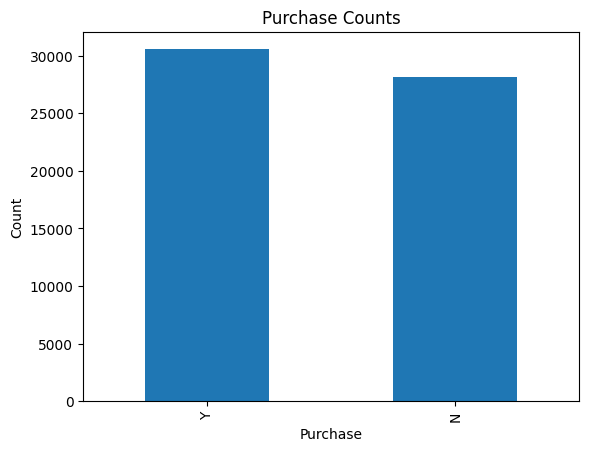

In [77]:
purchase_counts = phase_one['PURCHASE'].value_counts()

purchase_counts.plot(kind='bar')

plt.title('Purchase Counts')
plt.xlabel('Purchase')
plt.ylabel('Count')

plt.show()

In [78]:
purchase_counts

PURCHASE
Y    30536
N    28153
Name: count, dtype: int64

This gives us a much more even distribution between the classes. We choose this to be the penultimate prediction for our case.

In [79]:
phase_one.to_csv('submission.csv', index=False)